## predict sine wave from  2pi to 4pi

Training started...
Epoch 0, Loss: 0.469463
Epoch 50, Loss: 0.000026
Epoch 100, Loss: 0.000006
Epoch 150, Loss: 0.000053
Epoch 200, Loss: 0.000004
Epoch 250, Loss: 0.000001
Epoch 299, Loss: 0.000001


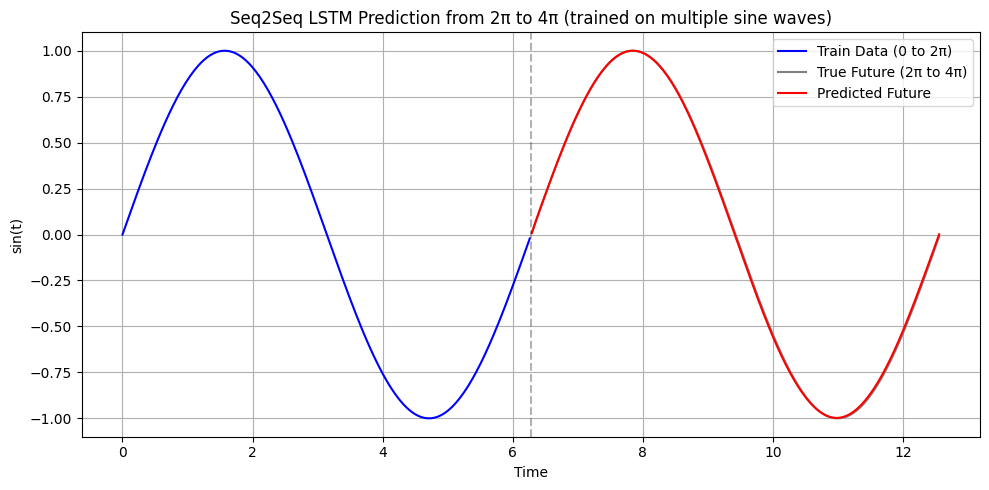

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Force CPU usage to avoid GPU/NCCL errors
device = torch.device("cpu")

# Generate sine wave: from 0 to 6π (to include multiple cycles)
t = np.linspace(0, 6 * np.pi, 600)
y = np.sin(t).reshape(-1, 1)

# Prediction target: from 2π to 4π
predict_start = int((2 * np.pi / (6 * np.pi)) * len(t))  # 200
predict_end = int((4 * np.pi / (6 * np.pi)) * len(t))    # 400
target_seq = y[predict_start:predict_end]
target_t = t[predict_start:predict_end]

# Hyperparameters
INPUT_SEQ = 50
OUTPUT_SEQ = predict_end - predict_start  # predict 200 steps (2π to 4π)
BATCH_SIZE = 32
EPOCHS = 300
LR = 0.001

# Create sequences from all training data (0 to 6π)
def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(y, INPUT_SEQ, OUTPUT_SEQ)
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.FloatTensor(Y_train)

train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)

    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x, h, c):
        out, (h, c) = self.lstm(x, (h, c))
        out = self.fc(out)
        return out, h, c

# Seq2Seq with teacher forcing
class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, src, target_seq=None, teacher_forcing_ratio=0.5):
        h, c = self.encoder(src)
        outputs = []
        decoder_input = src[:, -1].unsqueeze(1)
        for t in range(OUTPUT_SEQ):
            out, h, c = self.decoder(decoder_input, h, c)
            outputs.append(out)
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input = out
        return torch.cat(outputs, dim=1)

# Initialize model
model = Seq2Seq().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# Train model
print("Training started...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb, yb, teacher_forcing_ratio=0.5)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.6f}")

# Inference: predict 2π to 4π using input from just before 2π
with torch.no_grad():
    model.eval()
    test_input = torch.FloatTensor(y[predict_start - INPUT_SEQ:predict_start]).unsqueeze(0).to(device)
    pred_future = model(test_input, target_seq=None, teacher_forcing_ratio=0.0).squeeze(0).cpu().numpy()

# Plot
train_part = y[:predict_start]
train_t = t[:predict_start]

plt.figure(figsize=(10, 5))
plt.plot(train_t, train_part, label='Train Data (0 to 2π)', color='blue')
plt.plot(target_t, target_seq.squeeze(), label='True Future (2π to 4π)', color='gray')
plt.plot(target_t, pred_future.squeeze(), label='Predicted Future', color='red')
plt.axvline(x=2*np.pi, linestyle='--', color='black', alpha=0.3)
plt.legend()
plt.title("Seq2Seq LSTM Prediction from 2π to 4π (trained on multiple sine waves)")
plt.xlabel("Time")
plt.ylabel("sin(t)")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.474925
Epoch 50, Loss: 0.000435
Epoch 100, Loss: 0.000015
Epoch 150, Loss: 0.000060
Epoch 200, Loss: 0.000003
Epoch 250, Loss: 0.000157
Epoch 299, Loss: 0.000011


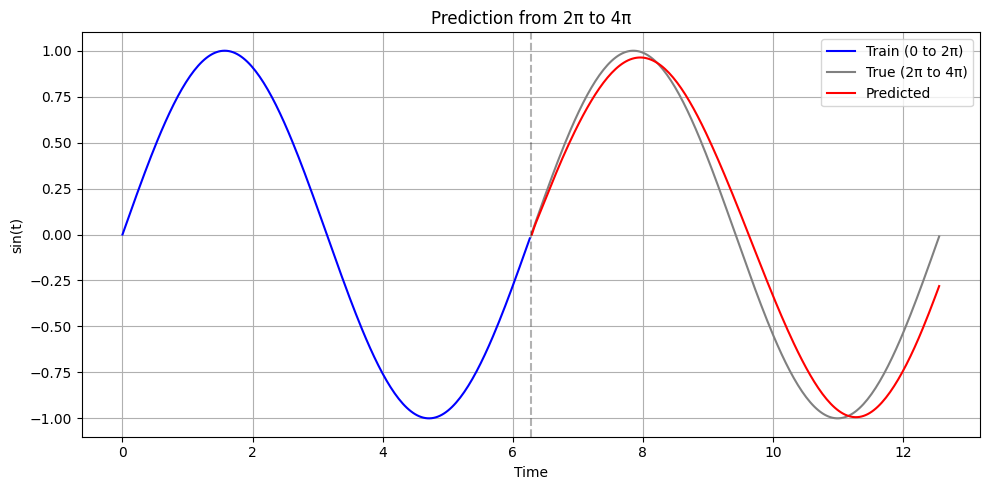

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate sine wave data from 0 to 6π
TOTAL_POINTS = 600
TOTAL_RANGE = 6 * np.pi
t = np.linspace(0, TOTAL_RANGE, TOTAL_POINTS)
y = np.sin(t).reshape(-1, 1)

# Hyperparameters
INPUT_SEQ = 50
BATCH_SIZE = 32
EPOCHS = 300
LR = 0.001

# Function to get index from π range
def get_indices(start_pi, end_pi, total_points=600, total_range=6 * np.pi):
    start = int((start_pi * np.pi / total_range) * total_points)
    end = int((end_pi * np.pi / total_range) * total_points)
    return start, end

# Create sequences for training
def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(Y)

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)

    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x, h, c):
        out, (h, c) = self.lstm(x, (h, c))
        return self.fc(out), h, c

# Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, output_seq_len):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.output_seq_len = output_seq_len

    def forward(self, src, target_seq=None, teacher_forcing_ratio=0.5):
        h, c = self.encoder(src)
        outputs = []
        decoder_input = src[:, -1].unsqueeze(1)

        for t in range(self.output_seq_len):
            out, h, c = self.decoder(decoder_input, h, c)
            outputs.append(out)
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input = out
        return torch.cat(outputs, dim=1)

# Training function
def train_model(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb, yb, teacher_forcing_ratio=0.5)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 or epoch == EPOCHS - 1:
            print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.6f}")

# Prediction function
def predict_wave(start_pi, end_pi):
    predict_start, predict_end = get_indices(start_pi, end_pi)
    OUTPUT_SEQ = predict_end - predict_start

    # Create training data
    X_train, Y_train = create_sequences(y, INPUT_SEQ, OUTPUT_SEQ)
    train_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train)),
        batch_size=BATCH_SIZE, shuffle=True
    )

    # Train new model
    model = Seq2Seq(output_seq_len=OUTPUT_SEQ).to(device)
    train_model(model, train_loader)

    # Predict using the model
    with torch.no_grad():
        model.eval()
        input_seq = y[predict_start - INPUT_SEQ:predict_start]
        test_input = torch.FloatTensor(input_seq).unsqueeze(0).to(device)
        pred_future = model(test_input, target_seq=None, teacher_forcing_ratio=0.0).squeeze(0).cpu().numpy()
        true_future = y[predict_start:predict_end].squeeze()
        t_pred = t[predict_start:predict_end]
        t_train = t[:predict_start]
        y_train = y[:predict_start]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t_train, y_train, label=f"Train (0 to {start_pi}π)", color="blue")
    plt.plot(t_pred, true_future, label=f"True ({start_pi}π to {end_pi}π)", color="gray")
    plt.plot(t_pred, pred_future, label="Predicted", color="red")
    plt.axvline(x=start_pi * np.pi, linestyle='--', color='black', alpha=0.3)
    plt.title(f"Prediction from {start_pi}π to {end_pi}π")
    plt.xlabel("Time")
    plt.ylabel("sin(t)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔧 Example usage
predict_wave(2, 4)  # You can change this to predict from any π range


## predict sine wave ( where pi should be 0<pi<6)

Epoch 0, Loss: 0.481111
Epoch 50, Loss: 0.000018
Epoch 100, Loss: 0.000018
Epoch 150, Loss: 0.000005
Epoch 200, Loss: 0.000019
Epoch 250, Loss: 0.000005
Epoch 299, Loss: 0.000006


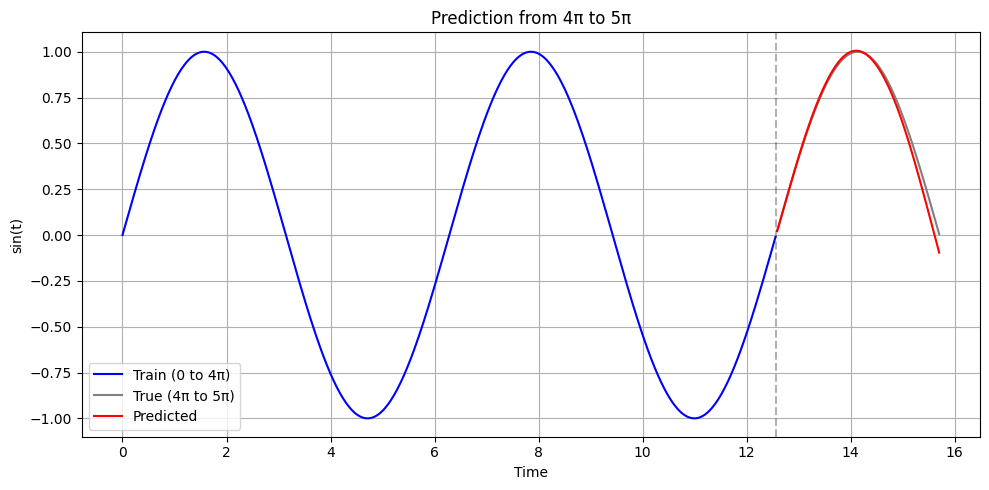

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate sine wave from 0 to 6π
TOTAL_POINTS = 600
TOTAL_RANGE = 6 * np.pi
t = np.linspace(0, TOTAL_RANGE, TOTAL_POINTS)
y = np.sin(t).reshape(-1, 1)

# Hyperparameters
INPUT_SEQ = 50
BATCH_SIZE = 32
EPOCHS = 300
LR = 0.001

# Convert π-ranges to index positions
def get_indices(start_pi, end_pi, total_points=600, total_range=6 * np.pi):
    start = int((start_pi * np.pi / total_range) * total_points)
    end = int((end_pi * np.pi / total_range) * total_points)
    return start, end

# Sequence creation function
def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(Y)

# Encoder LSTM
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)

    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c

# Decoder LSTM
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x, h, c):
        out, (h, c) = self.lstm(x, (h, c))
        return self.fc(out), h, c

# Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, output_seq_len):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.output_seq_len = output_seq_len

    def forward(self, src, target_seq=None, teacher_forcing_ratio=0.5):
        h, c = self.encoder(src)
        outputs = []
        decoder_input = src[:, -1].unsqueeze(1)

        for t in range(self.output_seq_len):
            out, h, c = self.decoder(decoder_input, h, c)
            outputs.append(out)
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input = out
        return torch.cat(outputs, dim=1)

# Training function
def train_model(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb, yb, teacher_forcing_ratio=0.5)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 or epoch == EPOCHS - 1:
            print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.6f}")

# Prediction + plotting
def predict_wave(start_pi, end_pi):
    predict_start, predict_end = get_indices(start_pi, end_pi)
    OUTPUT_SEQ = predict_end - predict_start

    # Training data
    X_train, Y_train = create_sequences(y, INPUT_SEQ, OUTPUT_SEQ)
    train_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train)),
        batch_size=BATCH_SIZE, shuffle=True
    )

    # Model
    model = Seq2Seq(output_seq_len=OUTPUT_SEQ).to(device)
    train_model(model, train_loader)

    # Predict
    with torch.no_grad():
        model.eval()
        input_seq = y[predict_start - INPUT_SEQ:predict_start]
        test_input = torch.FloatTensor(input_seq).unsqueeze(0).to(device)
        pred_future = model(test_input, target_seq=None, teacher_forcing_ratio=0.0)
        pred_future = pred_future.squeeze().cpu().numpy().reshape(-1)  # FIXED
        true_future = y[predict_start:predict_end].squeeze()
        t_pred = t[predict_start:predict_end]
        t_train = t[:predict_start]
        y_train = y[:predict_start]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t_train, y_train, label=f"Train (0 to {start_pi}π)", color="blue")
    plt.plot(t_pred, true_future, label=f"True ({start_pi}π to {end_pi}π)", color="gray")
    plt.plot(t_pred, pred_future, label="Predicted", color="red")
    plt.axvline(x=start_pi * np.pi, linestyle='--', color='black', alpha=0.3)
    plt.title(f"Prediction from {start_pi}π to {end_pi}π")
    plt.xlabel("Time")
    plt.ylabel("sin(t)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔧 Example: Predict from 2π to 4π
predict_wave(4, 5)
